In [1]:
# Train using pytorch
import time
import cupy as cp
import numpy as np
import math
import copy
from tqdm import tqdm
import os
import inspect
import matplotlib.pyplot as plt

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir)
from src.Tools import generate_inputWN,moving_bump
from src.Model_RLS import rnnLU
from src.RLS import Rls

# 1. fit output of RNN

In [2]:
n_step=41
dim_rec=300

Define an interesting 2-d sequential output pattern:

In [3]:
target=np.zeros((41,2))
for i in range(8):
    target[i,0]=1*np.cos(np.pi-np.pi/5*i)+1
    target[i,1]=1*np.sin(np.pi-np.pi/5*i)
target[8,0]=0.8
target[8,1]=-1.3
target[9,0]=0.4
target[9,1]=-1.6
for i in range(10,15):
    target[i,0]=target[0,0]+0.5*(i-10)
    target[i,1]=-2
for i in range(15,25):
    target[i,0]=1*np.cos(-np.pi/2-np.pi/5*(i-15))+3.7
    target[i,1]=1.5*np.sin(-np.pi/2-np.pi/5*(i-15))-0.5
for i in range(25,34):
    target[i,0]=2/1.8*np.cos(np.pi*6/5+np.pi/5*(i-25))+6.4
    target[i,1]=1*np.sin(np.pi*6/5+np.pi/5*(i-25))-1
target[34:36,0]=target[33,0]
target[34:36,1]=np.linspace(target[33,1],1,4)[1:3]
for i in range(36,41):
    target[i,0]=target[35,0]+0.5*(i-36)
    target[i,1]=1

Text(0, 0.5, 'y')

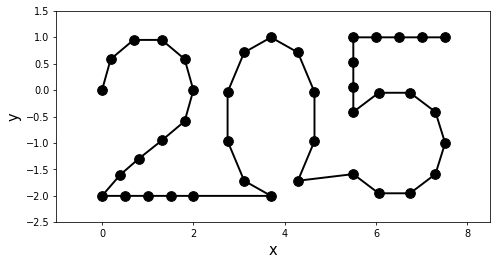

In [4]:
fig,ax=plt.subplots(figsize=(8,4),dpi=70)
plt.plot(target[:,0],target[:,1],marker='o',ms=10,c='k',lw=2)
plt.xlim(-1,8.5)
plt.ylim(-2.5,1.5)
plt.xlabel('x',size=15)
plt.ylabel('y',size=15)

Use filtered white noise as the inputs to the RNN - it is a rich source of dynamics

In [5]:
input=generate_inputWN(n_step=n_step,dim_rec=dim_rec,tauWN=1,ampWN=30,dt=0.001).astype('float32')

In [69]:
rnn=rnnLU(g=0.9, N=dim_rec)
optim=Rls(M=dim_rec,lr=1)

In [70]:
rnn.set_input(cp.array(input))
rnn.set_target(cp.array(target.T))
rnn.initialize_params()

In [71]:
rnn.set_params(J,W,Wfb)

In [72]:
pVar_lc,mse_lc,pred,best_W=rnn.train(optim,numEpoch=1000)

In [73]:
rnn.set_params(rnn.J,best_W,rnn.Wfb)
pred_best=rnn.run()

In [74]:
pred_best=cp.asnumpy(pred_best)

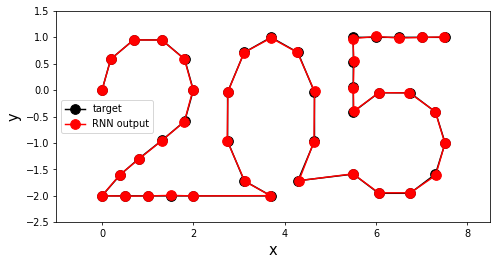

In [80]:
fig,ax=plt.subplots(figsize=(8,4),dpi=70)
plt.plot(target[:,0],target[:,1],marker='o',ms=10,c='k',label='target')
plt.plot(pred_best[0,:],pred_best[1,:],marker='o',ms=10,c='r',label='RNN output')
plt.xlim(-1,8.5)
plt.ylim(-2.5,1.5)
plt.xlabel('x',size=15)
plt.ylabel('y',size=15)
plt.legend(loc=6)

Text(0.5, 1.0, 'Learning curve')

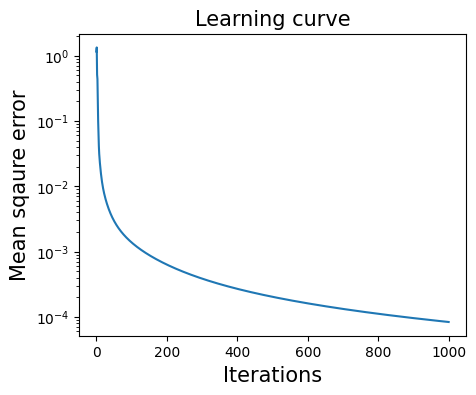

In [81]:
fig,ax=plt.subplots(figsize=(5,4),dpi=100)
plt.plot(cp.asnumpy(mse_lc))
plt.yscale('log')
plt.xlabel('Iterations',size=15)
plt.ylabel('Mean sqaure error',size=15)
plt.title('Learning curve',size=15)